In [1]:
#%%
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
#%% Data Loading and Preprocessing

np.random.seed(0)

# Load your data
data = pd.read_csv('state_action.csv', index_col=None)

# Select a subset of the data
data_size = 200000
selected_idx = np.random.randint(0, len(data) - 1, size=data_size)
data_select = data.iloc[selected_idx][['start_type', 'act_num', 'mode_num', 'end_type']]

# One-hot encode the selected data
encoder = OneHotEncoder(sparse_output=False)
one_hot_data = encoder.fit_transform(data_select.values)

# Convert the data to torch tensors
data_tensor = torch.tensor(one_hot_data, dtype=torch.float32)
dataset = TensorDataset(data_tensor)

# Set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create DataLoader with batch size 256
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

Using device: cuda:1


In [5]:

# Diffusion hyperparameters
T = 1000  # Number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

input_dim = one_hot_data.shape[1]
hidden_dim = 256

# Time embedding function
def get_timestep_embedding(timesteps, embedding_dim):
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb).float()
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb

# Define the neural network model
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_embedding_dim=128):
        super(DiffusionModel, self).__init__()
        self.time_embedding_dim = time_embedding_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.time_embedding_dim)
        x_t = torch.cat([x, t_emb], dim=1)
        return self.net(x_t)

# Initialize the model and optimizer
model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20


In [6]:
# Training the Diffusion Model

for epoch in range(num_epochs):
    for batch in data_loader:
        x_0 = batch[0].to(device)
        batch_size = x_0.size(0)
        t = torch.randint(0, T, (batch_size,), device=device).long()

        # Calculate diffusion coefficients
        sqrt_alpha_cumprod_t = sqrt_alphas_cumprod[t].unsqueeze(1)
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t].unsqueeze(1)

        # Forward diffusion (adding noise)
        noise = torch.randn_like(x_0)
        x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise

        # Predict the noise
        noise_pred = model(x_t, t)

        # Compute the loss (MSE between the true and predicted noise)
        loss = nn.MSELoss()(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.1169
Epoch 2/20, Loss: 0.1096
Epoch 3/20, Loss: 0.0958
Epoch 4/20, Loss: 0.0333
Epoch 5/20, Loss: 0.0679
Epoch 6/20, Loss: 0.0805
Epoch 7/20, Loss: 0.0420
Epoch 8/20, Loss: 0.0574
Epoch 9/20, Loss: 0.0690
Epoch 10/20, Loss: 0.0497
Epoch 11/20, Loss: 0.0497
Epoch 12/20, Loss: 0.0519
Epoch 13/20, Loss: 0.0355
Epoch 14/20, Loss: 0.0441
Epoch 15/20, Loss: 0.0539
Epoch 16/20, Loss: 0.0330
Epoch 17/20, Loss: 0.0453
Epoch 18/20, Loss: 0.0355
Epoch 19/20, Loss: 0.0381
Epoch 20/20, Loss: 0.0278


In [9]:
#%% Generating New Data

model.eval()
num_samples_gen = 3000
x_t = torch.randn(num_samples_gen, input_dim).to(device)

for t in reversed(range(T)):
    t_tensor = torch.full((num_samples_gen,), t, dtype=torch.long, device=device)
    beta_t = betas[t]
    sqrt_alpha_t = torch.sqrt(alphas[t])
    sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t]

    noise_pred = model(x_t, t_tensor)

    coef1 = 1 / sqrt_alpha_t
    coef2 = beta_t / sqrt_one_minus_alpha_cumprod_t
    mu = coef1 * (x_t - coef2 * noise_pred)

    if t > 0:
        z = torch.randn_like(x_t).to(device)
        x_t = mu + torch.sqrt(beta_t) * z
    else:
        x_t = mu

In [10]:
# Move data to CPU and convert to numpy
x_t_np = x_t.detach().cpu().numpy()

# Get the number of categories per feature
n_categories = [len(cat) for cat in encoder.categories_]
indices = np.cumsum([0] + n_categories)

# Map the one-hot encoded vectors back to original categories
generated_data = []
for sample in x_t_np:
    sample_categories = []
    for i in range(len(n_categories)):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        category_logits = sample[start_idx:end_idx]
        category_idx = np.argmax(category_logits)
        category_value = encoder.categories_[i][category_idx]
        sample_categories.append(category_value)
    generated_data.append(sample_categories)

generated_data = np.array(generated_data)
print("\nGenerated data:")
print(generated_data)



Generated data:
[[1. 2. 2. 1.]
 [0. 0. 0. 0.]
 [0. 1. 5. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 4. 0.]
 [0. 0. 0. 0.]]


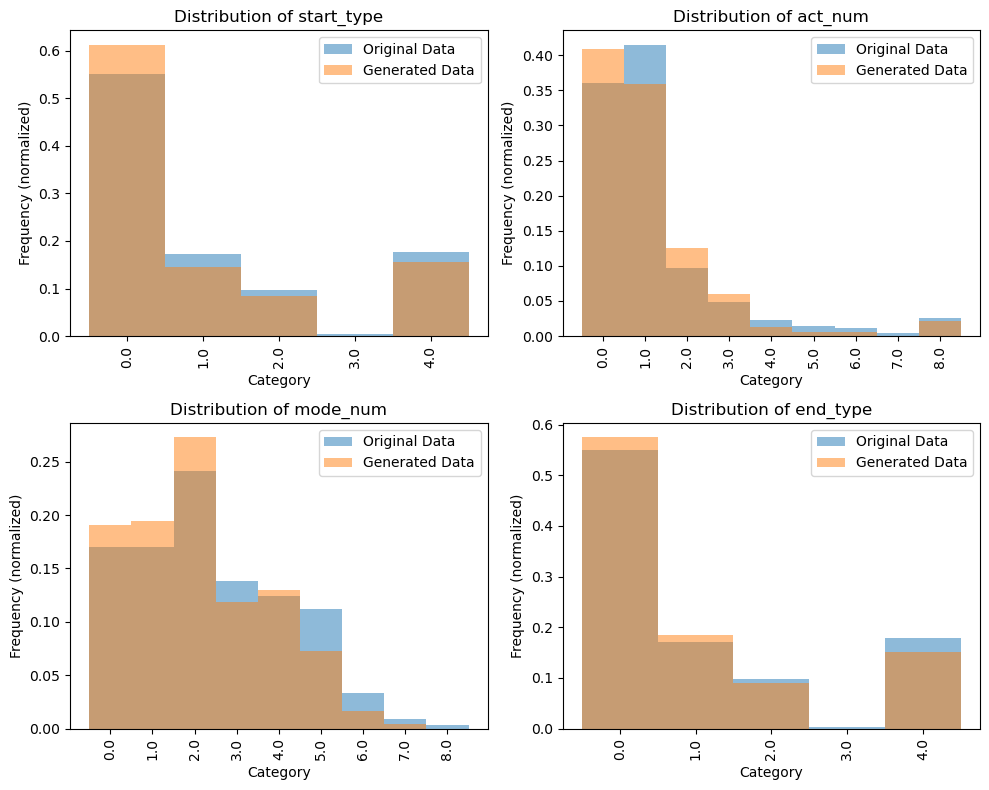

In [11]:
# Create a 2x2 grid of subplots for the four features
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Feature names for the title and accessing columns
features = ['start_type', 'act_num', 'mode_num', 'end_type']

# Plot each feature one by one
for i, ax in enumerate(axs.flat):
    # Original data histogram
    ax.hist(data_select.values[:, i], bins=np.arange(len(encoder.categories_[i]) + 1) - 0.5,
            density=True, alpha=0.5, label='Original Data')

    # Generated data histogram
    ax.hist(generated_data[:, i], bins=np.arange(len(encoder.categories_[i]) + 1) - 0.5,
            density=True, alpha=0.5, label='Generated Data')

    # Set titles, labels, and x-axis ticks
    ax.set_title(f'Distribution of {features[i]}')
    ax.set_xlabel('Category')
    ax.set_ylabel('Frequency (normalized)')
    ax.set_xticks(range(len(encoder.categories_[i])))
    ax.set_xticklabels(encoder.categories_[i], rotation=90)

    # Add a legend to each subplot
    ax.legend()

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

